In [1]:
import os
os.environ["TRANSCRIBEE_BACKEND_DATABASE_URL"] = "sqlite:///../db.sqlite"

In [2]:
from sqlalchemy.orm import joinedload
from sqlmodel import select
from transcribee_backend.db import get_session
from transcribee_backend.models import Task
import pandas as pd
import seaborn as sns

In [3]:
session = next(get_session())
tasks = session.exec(select(Task).options(joinedload(Task.document)))
tasks = list(tasks)

In [4]:
def extract_features(task: Task):
    task_duration = None
    if task.completed_at is not None and task.assigned_at is not None:
        task_duration = (task.completed_at - task.assigned_at).total_seconds()
    task_type = task.task_type
    if task.task_type == "TRANSCRIBE":
        task_type = f"{task.task_type}-{task.task_parameters['model']}"
    return {"task_type": task_type, "task_parameters": frozenset(task.task_parameters.items()), "doc_duration": task.document.duration, "task_duration_clock": task_duration}

df = pd.DataFrame([extract_features(x) for x in tasks])
df["real_time_factor"] = df.doc_duration / df.task_duration_clock
rtf_df = df.dropna(subset=["real_time_factor"])

In [5]:
rtf_means = rtf_df[["task_type", "real_time_factor"]].groupby(["task_type"]).agg("mean").reset_index()
rtf_means

,task_type,real_time_factor
0,ALIGN,14.705917
1,IDENTIFY_SPEAKERS,44.519128
2,REENCODE,97.932282
3,TRANSCRIBE-base,25.245807
4,TRANSCRIBE-large,2.335303


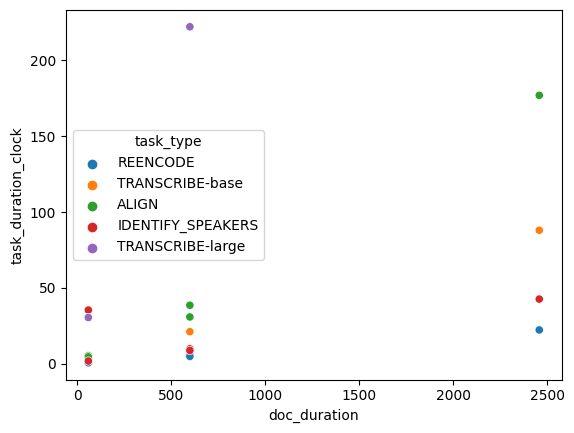

In [6]:
_ = sns.scatterplot(x=df.doc_duration, y=df.task_duration_clock, hue=df.task_type)

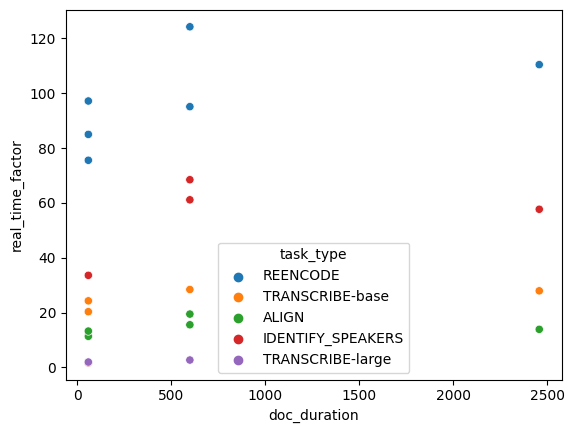

In [7]:
_ = sns.scatterplot(x=df.doc_duration, y=df.real_time_factor, hue=df.task_type)